# 5a - PCA classification: Bright Field data
Here, we will use Principal Component Analysis to reduce the dimensionality of the measured spectra, to visualize the spectra and to cluster the data, automatically assigning labels to different areas. First some preliminaries:

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from dask.distributed import Client, LocalCluster
import time
import os
import xarray as xr

from matplotlib.colors import LinearSegmentedColormap, ListedColormap


def to_niceRGB(image):
    """Use basis colors as suggested by P. Kovesi http://arxiv.org/abs/1509.03700"""
    A = np.array([[0.90, 0.17, 0.00],
                 [0.00, 0.50, 0.00],
                 [0.10, 0.33, 1.00]])
    return np.dot(image,A)

bRed = LinearSegmentedColormap.from_list('bRed', ['black', to_niceRGB([1,0,0])], N=256)
bBlue = LinearSegmentedColormap.from_list('bBlue', ['black', to_niceRGB([0,0,1])], N=256)
bGreen = LinearSegmentedColormap.from_list('bGreen', ['black', to_niceRGB([0,1,0])], N=256)
cmaps = [bRed, bGreen, bBlue]*2
colors = [to_niceRGB([1,0,0]), to_niceRGB([0,1,0]), to_niceRGB([0,0,1])]*2

SAVEFIG = True

#cluster = LocalCluster(n_workers=3, threads_per_worker=4, memory_limit='10GB')
client = Client()
client

C:\ProgramData\Anaconda3\lib\site-packages\distributed\dashboard\core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:56938' processes=4 threads=8, memory=34.23 GB>

## Load the data
We optionally coarsen the data by a factor `coarsen**2` to speed up the processing

In [16]:
tstart = time.time()
dimensions = 6
coarsen = 5

folder = r'./data'
name = '20171120_160356_3.5um_591.4_IVhdr'
Erange = slice(62, 460)
#Erange = slice(62, 160) # Alternative range to only show layer count differences
x_slice = slice(220, 1140)
y_slice = slice(160, 1050)
dset = da.from_zarr(os.path.join(folder, name + '_driftcorrected.zarr'))

IVs = dset[Erange, x_slice, y_slice].rechunk(chunks=(-1, 10 * coarsen, 10 * coarsen))
fullIVs = dset[:, x_slice, y_slice].rechunk(chunks=(-1, 10 * coarsen, 10 * coarsen))
IVs

dask.array<rechunk-merge, shape=(398, 920, 890), dtype=uint16, chunksize=(398, 50, 50), chunktype=numpy.ndarray>

In [17]:
coarseIVs = IVs[:,::coarsen, ::coarsen].reshape((IVs.shape[0],-1)).T.persist()
coarseIVs

dask.array<transpose, shape=(32752, 398), dtype=uint16, chunksize=(178, 398), chunktype=numpy.ndarray>

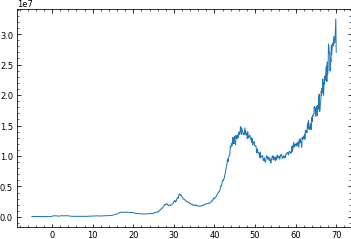

In [18]:
# Get metadata from netCDF file for plotting (Not saved in zarr of the driftcorrected)
xdata = xr.open_dataset(os.path.join(folder, name +'_detectorcorrected.nc'))
EGY = xdata.Energy_set
multiplier = xdata.multiplier
plt.plot(EGY, multiplier)

## Principal Component Analysis
To reduce the data to a reasonable number of dimensions, we use a pipeline of a standardscaler and PCA:

In [19]:
pca = PCA(n_components=dimensions, whiten=True, random_state=4)
pipe = make_pipeline(StandardScaler(), pca)
pipe_names = '_'.join(pipe.named_steps.keys())

In [20]:
pipe.fit(coarseIVs)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power=0, n_components=6,
                     random_state=4, svd_solver='auto', tol=0.0,
                     whiten=True))],
         verbose=False)

To determine a reasonable value for the number of dimensions to reduce to, we create a _scree_ plot:

'6 PCA components explain 0.9296 of the total variance'

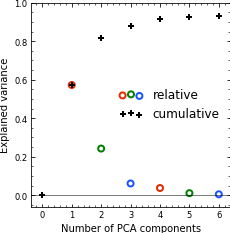

In [21]:
plt.figure(figsize=[3.5, 3.5])
scree = np.concatenate([[0], pipe.named_steps['pca'].explained_variance_ratio_])
plt.scatter(np.arange(0,dimensions)+1, scree[1:], label='relative', facecolors='none', edgecolors=colors, linewidth=2)
plt.scatter(np.arange(dimensions+1), np.cumsum(scree), marker='+', label='cumulative', color='black', linewidth=2)
plt.ylabel('Explained variance')
plt.xlabel('Number of PCA components')
plt.axhline(0, color='black', alpha=0.5)
plt.legend(fontsize='large', scatterpoints=3)
plt.tight_layout()
plt.ylim([None,1])
if SAVEFIG:
    plt.savefig(f'scree_plot_BF_{pipe_names}.pdf')
f"{dimensions} PCA components explain {scree.sum():.4f} of the total variance"

The sign of the PCA vectors has a degeneracy dependent on the random initialization: minus a PCA vector explains as much variance as plus the vector, as we take a linear span.

To make the visualization reproducible, the degeneracy of the sign of the PCA components needs to be lifted. Here, we align the signs such that positive vector corresponds to being brighter in the majority of the images.
After this we can transform all original data to the reduced number of dimensions

In [22]:
pipe_diffs = pipe.inverse_transform(np.eye(dimensions)).compute()
signs = np.sign(np.nanmean((np.log(pipe_diffs) - 
                            np.log(pipe.named_steps['standardscaler'].mean_)),
                           axis=1))
pipe.named_steps['pca'].components_ *= signs[:,np.newaxis]
signs

array([-1.,  1., -1.,  1., -1.,  1.])

In [23]:
# Reduce the IVs (spectra) to their low dimensional projections
rIVs = pipe.transform(IVs.reshape(IVs.shape[0], -1).T).persist()

To visualize the dimension reduction, we calculate the spectra corresponding to the extrema of the components, as well as the spectra _occuring in the dataset_ with the extreme values of the components:

In [24]:
argextrema = da.concatenate([rIVs[rIVs.argmin(axis=0), :], 
                             rIVs[rIVs.argmax(axis=0), :]])
argextrema = pipe.inverse_transform(argextrema) / multiplier[Erange]
argextrema = argextrema.reshape((2, 6, -1))

extrema = da.concatenate([da.diag(rIVs.min(axis=0)), 
                          da.diag(rIVs.max(axis=0))])
extrema = pipe.inverse_transform(extrema) / multiplier[Erange]
extrema = extrema.reshape((2, 6, -1))

argextrema, extrema = da.compute(argextrema, extrema)

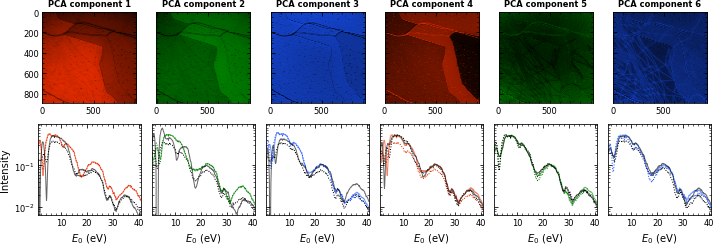

In [25]:
fig,axs = plt.subplots(2, dimensions, figsize=[10, 3.5],
                      sharex='row', sharey='row',
                      constrained_layout=True)
E = EGY[Erange]
for i in range(dimensions):
    axs[0,i].imshow(rIVs[:,i].reshape(IVs.shape[1:]).T, interpolation='none', cmap=cmaps[i])
    axs[0,i].set_title('PCA component {}'.format(i+1), fontsize='small')
    axs[1,i].plot(E, argextrema[1][i], color=cmaps[i](1.0), linestyle=':')
    axs[1,i].plot(E, argextrema[0][i], color=cmaps[i](0.0), linestyle=':')
    axs[1,i].plot(E, extrema[1][i], color=cmaps[i](1.0), alpha=0.6)
    axs[1,i].plot(E, extrema[0][i], color=cmaps[i](0.0), alpha=0.6)
    axs[1,i].set_yscale('log')
    axs[1,i].set_xlabel('$E_0$ (eV)')
    axs[1,i].margins(x=0)
axs[1,0].set_ylabel('Intensity')
#plt.tight_layout()
if SAVEFIG:
    plt.savefig(f'BF_PCAcomponents_{pipe_names}.pdf')

## Visualization

To visualize the dataset, we combine the PCA components in groups of three, and use these as RGB images in real space:

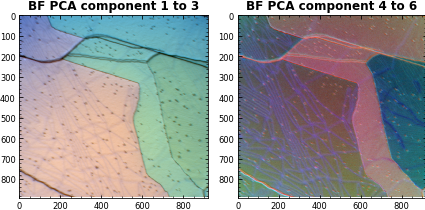

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[6, 3], constrained_layout=True)
img = rIVs[:, :3].reshape(IVs.shape[1:] + (3,)).swapaxes(0, 1)
img = img - img.min(axis=(0, 1), keepdims=True)
img = img / img.max(axis=(0, 1), keepdims=True)
ax1.imshow(to_niceRGB(img), interpolation='none')
ax1.set_title('BF PCA component 1 to 3')

img = rIVs[:, 3:6].reshape(IVs.shape[1:] + (3,)).swapaxes(0, 1)
img = img - img.min(axis=(0, 1), keepdims=True)
img = img / img.max(axis=(0, 1), keepdims=True)
ax2.imshow(to_niceRGB(img), interpolation='none')
ax2.set_title('BF PCA component 4 to 6')
#plt.tight_layout()
if SAVEFIG:
    plt.savefig(f'BF2_visualization_{pipe_names}.pdf')

## Clustering: $k$-means
To assign labels to different spectra, we cluster using a standard unsupervised machine learning algorithm: the $k$-means clustering algorithm:

In [27]:
rIVs = rIVs.compute()
kmeans_d = 6 # number of PCA components to use in the k-means clustering

4 fit_predicted
4 clusters, score = 0.3081006822018449
5 fit_predicted
5 clusters, score = 0.3267320446110219
6 fit_predicted
6 clusters, score = 0.33095926756368726
7 fit_predicted
7 clusters, score = 0.3401480153965028
8 fit_predicted
8 clusters, score = 0.3561123540518596
9 fit_predicted
9 clusters, score = 0.3639453318680235
10 fit_predicted
10 clusters, score = 0.3687618903733131


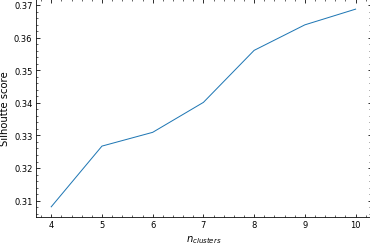

In [28]:
# Optionally, calculate the silhouette score for different numbers of clusters and dimensions
# to find an indication of a good choice of parameters
# See https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
scores = []
klabels = range(4, 11)
for n in klabels:
    clusterer = KMeans(n_clusters=n, random_state=10, n_jobs=-1)
    cl_labels = clusterer.fit_predict(rIVs[::20,:kmeans_d])
    print(n, "fit_predicted")
    scores.append(silhouette_score(rIVs[::20,:kmeans_d], cl_labels))
    print(f"{n} clusters, score = {scores[-1]}")
plt.plot(klabels, scores)
plt.ylabel('Silhoutte score')
plt.xlabel('$n_{clusters}$');

In [29]:
# Perform the actual clustering
kmeans = KMeans(n_clusters=5, random_state=10, n_jobs=-1).fit(rIVs[:,:kmeans_d])
clustering = kmeans.predict(rIVs[:,:kmeans_d])

For visualization of curves corresponding to clusters, we grab the full spectra, filter out points where the spectrum was not measured due to drift and calculate the mean per image per spectrum.

In [30]:
validIVs = da.where(fullIVs == 0, np.nan, fullIVs).reshape((fullIVs.shape[0],-1))
meanIVs = [da.nanmean(validIVs[:,clustering == index], axis=1) 
           for index in range(kmeans.n_clusters)]

plotting clustering data
Time elapsed: 0.7018716335296631
Time elapsed: 26.963523626327515
Time elapsed: 28.30911111831665
Total time elapsed: 38.94156503677368


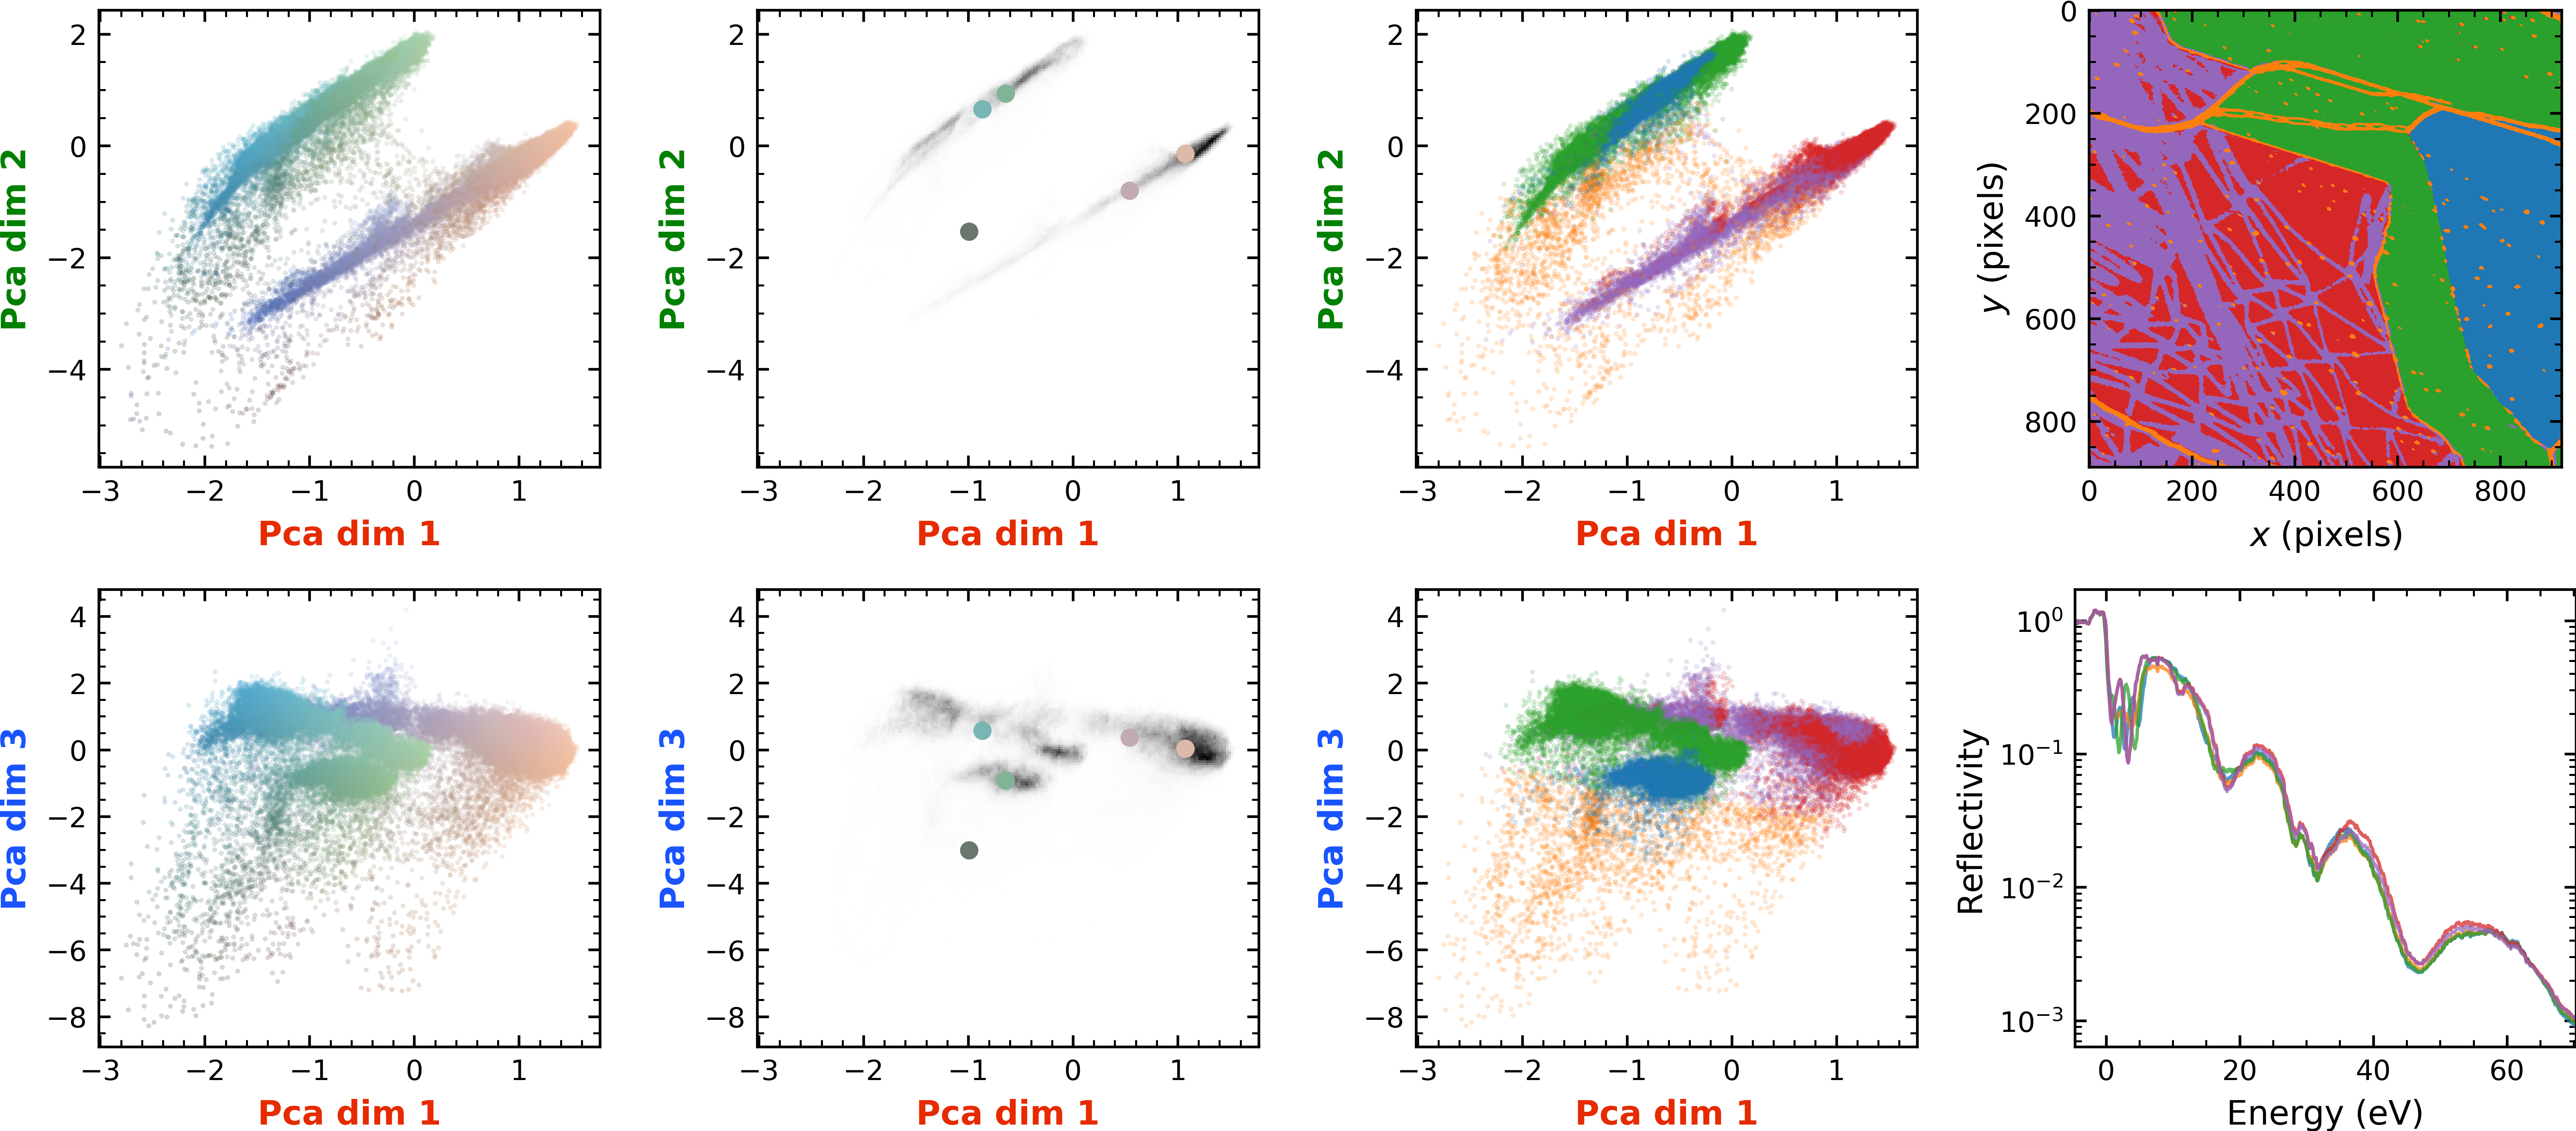

In [31]:
tstart = time.time()
print('plotting clustering data')


fig2,axs = plt.subplots(2,4, figsize=[11,5], dpi=600)
#In case of 1 out of 1 columns figure
axs = np.transpose(axs)

coarse_2d = 3*coarsen
color = rIVs[::coarse_2d,:3]
center_colors = kmeans.cluster_centers_[:,:3] - color.min(axis=0)
color = color - color.min(axis=0, keepdims=True)
center_colors = center_colors / color.max(axis=0)
center_colors = to_niceRGB(center_colors)
color = color / color.max(axis=0,keepdims=True)
color = to_niceRGB(color)

newcmap = ListedColormap(center_colors)

colorargs = {'cmap': newcmap, 'vmin': 0, 'vmax': kmeans.n_clusters}
axs[0,0].scatter(rIVs[::coarse_2d, 0], 
                 rIVs[::coarse_2d, 1], 
                 c=color, s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )
axs[0,1].scatter(rIVs[::coarse_2d, 0], 
                 rIVs[::coarse_2d, 2], 
                 c=color, s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )

for i in [0,1,2]:
    axs[i,0].set_ylabel("Pca dim 2", color=colors[1], fontweight=700)
    axs[i,0].set_xlabel("Pca dim 1", color=colors[0], fontweight=700)
    axs[i,1].set_ylabel("Pca dim 3", color=colors[2], fontweight=700)
    axs[i,1].set_xlabel("Pca dim 1", color=colors[0], fontweight=700)

hist, edges = np.histogramdd(rIVs[:,:3], bins=200,
                             range=[axs[0,0].get_xlim(), 
                                    axs[0,0].get_ylim(), 
                                    axs[0,1].get_ylim()])
edges = np.array(edges)

axs[1,0].imshow(hist.sum(axis=-1)[:,::-1].T,
                extent=[edges[0,0], edges[0,-1], 
                        edges[1,0], edges[1,-1]],
                aspect='auto',
                cmap='gray_r')

axs[1,1].imshow(hist.sum(axis=1)[:,::-1].T, 
                extent=[edges[0,0], edges[0,-1],
                        edges[2,0], edges[2,-1]], 
                aspect='auto',
                cmap='gray_r')
colorargs['cmap'] = 'tab10'
colorargs['vmax'] = 10

axs[2,0].scatter(rIVs[::coarse_2d,0], rIVs[::coarse_2d,1], c=clustering[::coarse_2d], s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )
axs[2,1].scatter(rIVs[::coarse_2d,0], rIVs[::coarse_2d,2], c=clustering[::coarse_2d], s=0.2, alpha=0.2,
                 **colorargs, rasterized=True,
                 )

clusteringimg = clustering.reshape((IVs.shape[1],IVs.shape[2]))
axs[3,0].imshow(clusteringimg.T,
                **colorargs
                )
for i,v in enumerate(kmeans.cluster_centers_):
    axs[1,0].scatter(v[0], v[1], s=20, color=center_colors[i])
    axs[1,1].scatter(v[0], v[2], s=20, color=center_colors[i])
print("Time elapsed: {}".format(time.time()-tstart))
meanIVs = da.compute(*meanIVs)
print("Time elapsed: {}".format(time.time()-tstart))
for i, meanIV in enumerate(meanIVs):
    axs[3,1].plot(xdata.Energy, (meanIV / multiplier), alpha=0.75)#, color=center_colors[i],)

axs[3,1].set_yscale('log')
axs[3,1].set_xlabel('Energy (eV)')
axs[3,1].set_ylabel('Reflectivity')
axs[3,1].margins(x=0)
axs[3,0].set_xlabel(r'$x$ (pixels)')
axs[3,0].set_ylabel(r'$y$ (pixels)')

#In case of 1 out of two columns figure
#for ax in axs[:,1]:
    #ax.yaxis.set_label_position("right")
    #ax.tick_params(axis='y', labelright=True, labelleft=False)
    
plt.tight_layout()
print("Time elapsed: {}".format(time.time()-tstart))
if SAVEFIG:
    plt.savefig('clustering_BF_2_0_perp.pdf', dpi=600)
print("Total time elapsed: {}".format(time.time()-tstart))

In [32]:
from mpl_toolkits.mplot3d import Axes3D 
xx,yy = np.meshgrid(edges[0], edges[1])

In [33]:
%matplotlib inline
coarsen3d = coarsen
color = rIVs[::coarsen3d,:3]
color = color - color.min(axis=0, keepdims=True)
color = color / color.max(axis=0,keepdims=True)
color = to_niceRGB(color)
xx,yy = np.meshgrid(edges[0][:-1], edges[1][:-1])

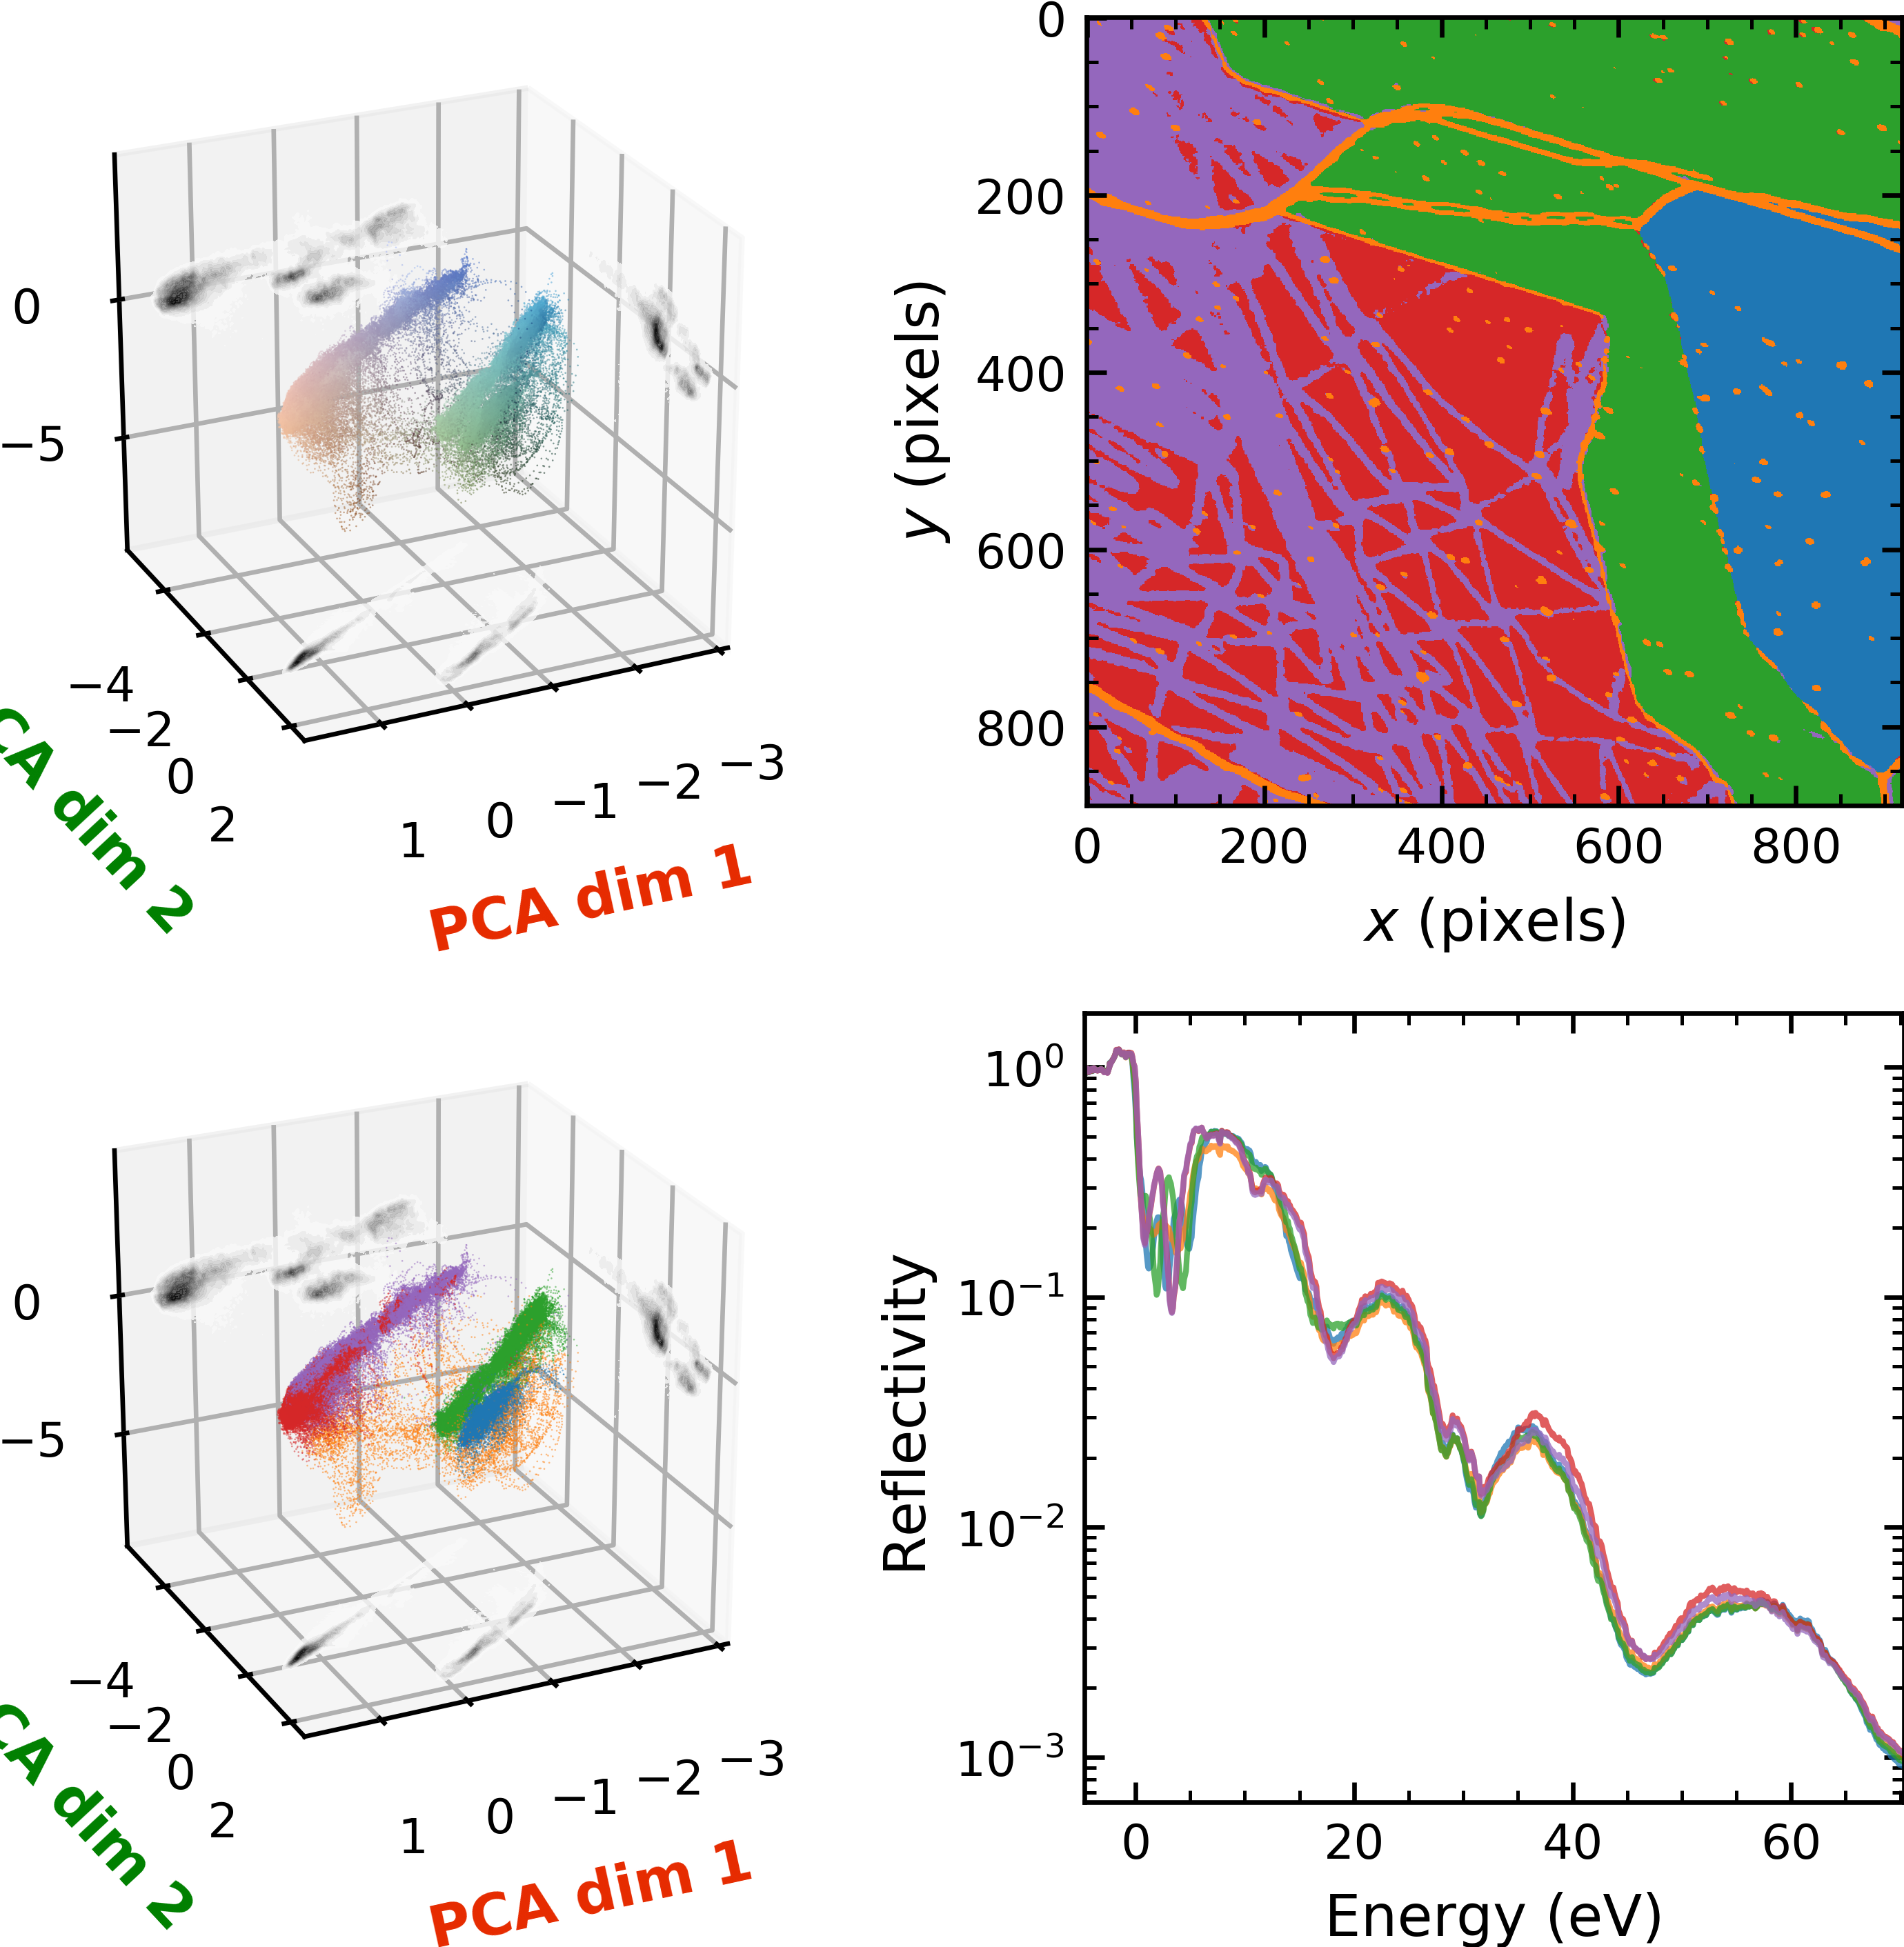

In [34]:
fig = plt.figure(figsize=[5,5], dpi=600)
axs = np.array([[fig.add_subplot(221, projection='3d'), fig.add_subplot(222)], 
       [fig.add_subplot(223, projection='3d'), fig.add_subplot(224)]])

axs[0,0].view_init(25, 65)
axs[0,0].scatter(rIVs[::coarsen3d,0], rIVs[::coarsen3d,1], rIVs[::coarsen3d,2], 
           c=color,
           s=0.1, alpha=0.5,
           rasterized=True,
           linewidths=0,
           #edgecolors='none',
           **colorargs
            )

colorargs['cmap'] = 'tab10'
colorargs['vmax'] = 10
axs[1,0].view_init(25, 65)
axs[1,0].scatter(rIVs[::coarsen3d,0], rIVs[::coarsen3d,1], rIVs[::coarsen3d,2], 
                 c=clustering[::coarsen3d], 
                 s=0.1, alpha=0.5,
                 rasterized=True,
                 linewidths=0,
                 **colorargs
                 )
xx,zz = np.meshgrid(edges[0][:-1], edges[2][:-1])
for ax in [axs[0,0],axs[1,0]]:
    cset = ax.contourf(*np.meshgrid(edges[0][:-1], edges[1][:-1]), 
                      hist.sum(axis=2).T, 
                      zdir='z', offset=edges[2][0], cmap='gray_r',
                      levels = np.linspace(20,hist.sum(axis=2).max(),20), alpha=0.8,
                      )
    cset = ax.contourf(xx, hist.sum(axis=1).T, zz,
                      zdir='y', offset=edges[1][0], cmap='gray_r',
                      levels = np.linspace(20,hist.sum(axis=1).max(),20), alpha=0.8,
                      )
    cset = ax.contourf(hist.sum(axis=0).T, *np.meshgrid(edges[1][:-1], edges[2][:-1]), 
                      zdir='x', offset=edges[0][0], cmap='gray_r',
                      levels = np.linspace(20,hist.sum(axis=0).max(),20), alpha=0.8,
                      )
    ax.minorticks_off()
    ax.set_zticks([], minor=True)
    ax.margins(0)


for ax in [axs[0,0],axs[1,0]]:
    ax.set_xlabel('PCA dim 1', color=colors[0], fontweight=700)
    ax.set_ylabel('PCA dim 2', color=colors[1], fontweight=700)
    ax.set_zlabel('PCA dim 3', color=colors[2], fontweight=700)
    ax.set_xlim(edges[0][0],edges[0][-1])
    ax.set_ylim(edges[1][0],edges[1][-1])
    ax.set_zlim(edges[2][0],edges[2][-1])
    ax.grid(True, which='major', linewidth=1)

axs[0,1].imshow(clusteringimg.T,
                **colorargs
                )
for i, meanIV in enumerate(meanIVs):
    axs[1,1].plot(xdata['Energy'], (meanIV / multiplier), alpha=0.75)
    
axs[1,1].set_yscale('log')
axs[1,1].set_xlabel('Energy (eV)')
axs[1,1].set_ylabel('Reflectivity')
axs[1,1].margins(x=0)
axs[0,1].set_xlabel(r'$x$ (pixels)')
axs[0,1].set_ylabel(r'$y$ (pixels)')
plt.tight_layout()
plt.subplots_adjust(left=0.05)
if SAVEFIG:
    plt.savefig('BF_clustering3D.pdf', dpi=600)
plt.show()